In [195]:
import pandas as pd
import os, glob, cv2 as cv, math, random
import cv2
import numpy as np
import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image as III
from IPython.display import Image
from IPython.display import display
import random
from matplotlib import animation, rc
import matplotlib.pyplot as plt
from scipy.ndimage import convolve
from collections import Counter
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import logging, os, sys
from logging.handlers import RotatingFileHandler

In [6]:
from math import inf

def tsp_min_cycle(cost):
    n = len(cost)
    N = 1 << n
    # dp[mask][i] = min cost to reach set 'mask' and end at node i
    dp = [[inf] * n for _ in range(N)]
    dp[1 << 0][0] = 0  # start at node 0, mask has only 0

    for mask in range(N):
        if not (mask & 1):  # ensure tours start from node 0 (optional pruning)
            continue
        for i in range(n):
            if not (mask & (1 << i)):
                continue
            cur = dp[mask][i]
            if cur == inf:
                continue
            # try to go to j not yet in mask
            remaining = (~mask) & (N - 1)
            j = remaining
            while j:
                lsb = j & -j
                v = (lsb.bit_length() - 1)
                nxt = mask | (1 << v)
                dp[nxt][v] = min(dp[nxt][v], cur + cost[i][v])
                j -= lsb

    full = N - 1
    ans = min(dp[full][i] + cost[i][0] for i in range(n))
    return ans

EDA

In [198]:
df= pd.read_csv('/Users/wmeikle/Downloads/archive-2/info.txt', sep ='\t', header = 0, names = ['filename', 'date(yyyymmdd)', 'timestamp', 'direction', 'day/night', 'weather', 'start frame', 'number of frames', 'class', 'notes'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 254 entries, 0 to 253
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   filename          254 non-null    object 
 1   date(yyyymmdd)    254 non-null    int64  
 2   timestamp         254 non-null    float64
 3   direction         254 non-null    object 
 4   day/night         254 non-null    object 
 5   weather           254 non-null    object 
 6   start frame       254 non-null    int64  
 7   number of frames  254 non-null    int64  
 8   class             254 non-null    object 
 9   notes             14 non-null     object 
dtypes: float64(1), int64(3), object(6)
memory usage: 20.0+ KB


In [200]:
df.isna().sum()

filename              0
date(yyyymmdd)        0
timestamp             0
direction             0
day/night             0
weather               0
start frame           0
number of frames      0
class                 0
notes               240
dtype: int64

In [202]:
def read_video_segment(in_path, vid_seg = None):
    cap = cv.VideoCapture(in_path)
    video_length = int(cap.get(cv.CAP_PROP_FRAME_COUNT)) - 1
    frames = []
    if cap.isOpened() and video_length > 0:
        frame_ids = [0]
        if vid_seg is None:
            vid_seg = np.array([0, 0.25, 0.5, 0.75, 1])
        else:
            vid_seg = np.clip(vid_seg, 0, 1)
        frame_ids = np.clip(video_length*vid_seg, 0, video_length-1).astype(int)
        count = 0
        success, image = cap.read()
        print('Loaded', video_length, 'frames at', image.shape, 'resolution')
        while success:
            if count in frame_ids:
                frames.append(image)
            success, image = cap.read()
            count += 1
    return frames

In [204]:
vpath= os.path.join( "/Users/wmeikle/Downloads/archive-2/video/", 'cctv052x2004080516x01638.avi' )
frames = read_video_segment( vpath )

Loaded 52 frames at (240, 320, 3) resolution


[msmpeg4v1 @ 0x12d08fac0] ext header missing, 6 left


5
(240, 320, 3)


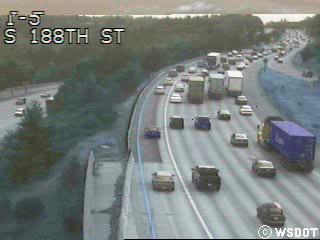

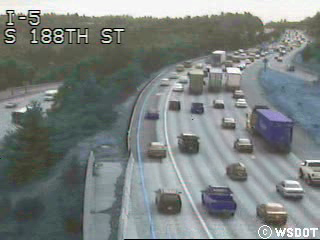

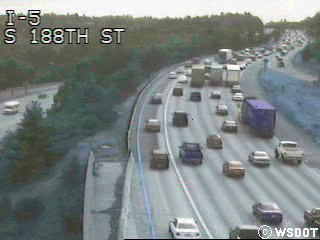

In [206]:
print( len(frames) )
print( frames[0].shape )
img_0 = frames[0]
img_1 = frames[1]
img_2 = frames[2]
out_image = cv.cvtColor( img_0, cv.COLOR_BGR2RGB)
display(III.fromarray(img_0))
out_image = cv.cvtColor( img_1, cv.COLOR_BGR2RGB)
display(III.fromarray(img_1))
out_image = cv.cvtColor( img_2, cv.COLOR_BGR2RGB)
display(III.fromarray(img_2))

Using a CNN-LSTM model, we can track the movement of the vehicles in the above image over a period of time. 

In [209]:
# OpenCV magic
def sparse_flow( old_frame, frame ):
    # params for ShiTomasi corner detection
    feature_params = dict( maxCorners = 100,
                           qualityLevel = 0.3,
                           minDistance = 7,
                           blockSize = 7 )
    # Parameters for lucas kanade optical flow
    lk_params = dict( winSize  = (15, 15),
                      maxLevel = 2,
                      criteria = (cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_COUNT, 10, 0.03))
    # Create some random colors
    color = np.random.randint(0, 255, (100, 3))
    
    old_gray = cv.cvtColor(old_frame, cv.COLOR_BGR2GRAY)
    frame_gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)

    p0 = cv.goodFeaturesToTrack(old_gray, mask = None, **feature_params)
    print ( "good features found: ", p0.shape)
    #print (p0)
    # Create a mask image for drawing purposes
    mask = np.zeros_like(old_frame)
    
    p1, st, err =  cv.calcOpticalFlowPyrLK( old_frame, frame, p0, None, **lk_params  )
    # Select good points
    if p1 is not None:
        good_new = p1[st==1]
        good_old = p0[st==1]
    # draw the tracks
    for i, (new, old) in enumerate(zip(good_new, good_old)):
        a, b = new.ravel()
        c, d = old.ravel()
        mask = cv.line(np.zeros_like(frame), 
                       (int(a), int(b)), (int(c), int(d)), color[i].tolist(), 2)
        frame = cv.circle(frame, (int(a), int(b)), 1, color[i].tolist(), -1)
        frame = cv.add(frame, mask)
    return np.uint8(frame)

In [211]:
rc('animation', html='jshtml')

global im
def create_animation(ims):
    fig=plt.figure(figsize=(12,4))
    #plt.axis('off')
    def a_init():
        global im
        #im=plt.imshow(cv.cvtColor(ims[0],cv.COLOR_BGR2RGB))
    
    def a_func(i):
        global im
        im.set_array(cv.cvtColor(ims[i],cv.COLOR_BGR2RGB))
        return [im]

    return animation.FuncAnimation(fig, a_func, frames=len(ims), 
                                   interval=1000, init_func=a_init,)

MovieWriter imagemagick unavailable; using Pillow instead.


good features found:  (53, 1, 2)
good features found:  (19, 1, 2)


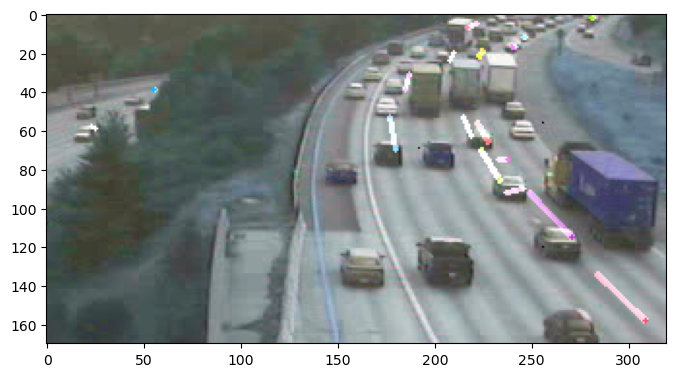

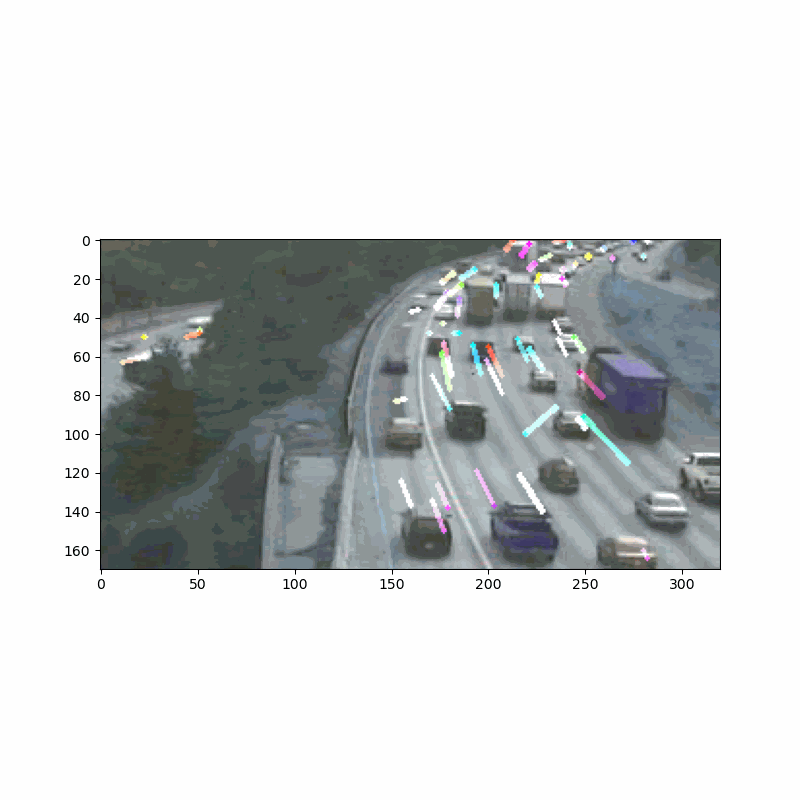

In [213]:
fig = plt.figure(figsize=(8,8))

img_painted = sparse_flow( img_0[50:220], img_1[50:220] )
im0 =plt.imshow(img_painted, animated=True)
img_painted = sparse_flow( img_1[50:220], img_0[50:220] )
im1 =plt.imshow(img_painted, animated=True)
ani = animation.ArtistAnimation(fig, [ [im0], [im1] ])
ani.save('animit.gif', writer='imagemagick', fps=5)

plt.show()
Image("animit.gif")

Machine Learning Model

In [216]:

# Utilities
def uniform_indices(num_frames, T):
    if num_frames <= 0:
        return []
    idx = np.linspace(0, num_frames-1, T).astype(int)
    return idx.tolist()

def read_clip_cv2(path, T=16, size=112):
    cap = cv2.VideoCapture(path)
    n = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    idxs = uniform_indices(n, T)
    frames = []
    for j, i in enumerate(idxs):
        cap.set(cv2.CAP_PROP_POS_FRAMES, int(i))
        ok, frame = cap.read()
        if not ok:
            # fall back: duplicate last good frame or zeros
            frame = frames[-1] if frames else np.zeros((size, size, 3), np.uint8)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = cv2.resize(frame, (size, size), interpolation=cv2.INTER_AREA)
        frames.append(frame)
    cap.release()
    clip = np.stack(frames, axis=0).astype("float32") / 255.0  # (T,H,W,C)
    return clip

def pseudo_label_day_night(path, sample_frames=24, thresh=0.45):
    cap = cv2.VideoCapture(path)
    n = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    idxs = uniform_indices(n, sample_frames)
    vals = []
    for i in idxs:
        cap.set(cv2.CAP_PROP_POS_FRAMES, int(i))
        ok, f = cap.read()
        if not ok: continue
        g = cv2.cvtColor(f, cv2.COLOR_BGR2GRAY)
        vals.append(g.mean()/255.0)
    cap.release()
    if not vals: return 0
    mean_brightness = float(np.mean(vals))
    return 1 if mean_brightness < thresh else 0


# Dataset

class HighwayVideoClips(Dataset):
    
    def __init__(self, root, T=16, size=112, train=True, split=0.8, cache_labels=True):
        self.paths = sorted([p for p in glob.glob(os.path.join(root, "**", "*.avi"), recursive=True)])
        assert self.paths
        # split
        k = int(len(self.paths)*split)
        self.paths = self.paths[:k] if train else self.paths[k:]
        self.T, self.size = T, size
        # pseudo-labels
        self.labels = {}
        if cache_labels:
            for p in self.paths:
                self.labels[p] = pseudo_label_day_night(p)

    def __len__(self): return len(self.paths)

    def __getitem__(self, idx):
        p = self.paths[idx]
        y = self.labels[p] if p in self.labels else pseudo_label_day_night(p)
        clip = read_clip_cv2(p, self.T, self.size)      # (T,H,W,C) in [0,1]
        clip = clip.transpose(3,0,1,2)                  # -> (C,T,H,W)
        x = torch.from_numpy(clip)                      # float32
        y = torch.tensor(y, dtype=torch.long)
        return x, y

    def summarize_counts(self, counts, class_names=None, title="Class distribution"):
        ks = sorted(counts.keys())
        vs = np.array([counts[k] for k in ks])
        plt.hist(vs, bins='auto', edgecolor='black')
        plt.xlabel("Value")
        plt.ylabel("Frequency")
        plt.title("Frequency Histogram Distribution")

# 4. Display the Histogram
plt.show()

# Small 3D-CNN (from earlier)
class Simple3DCNN(nn.Module):
    def __init__(self, num_classes=2, in_ch=3):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv3d(in_ch, 64, kernel_size=3, padding=1),
            nn.BatchNorm3d(64), nn.ReLU(inplace=True),
            nn.MaxPool3d((1,2,2)),

            nn.Conv3d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm3d(128), nn.ReLU(inplace=True),
            nn.MaxPool3d((2,2,2)),

            nn.Conv3d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm3d(256), nn.ReLU(inplace=True),
            nn.MaxPool3d((2,2,2)),
        )
        self.pool = nn.AdaptiveAvgPool3d((1,1,1))
        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):           # x: (B,C,T,H,W)
        x = self.features(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

# Train/Eval

def train_one_epoch(model, loader, opt, loss_fn, device):
    model.train()
    total, correct, loss_sum = 0, 0, 0.0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        opt.zero_grad()
        logits = model(x)
        loss = loss_fn(logits, y)
        loss.backward(); opt.step()
        loss_sum += float(loss) * x.size(0)
        pred = logits.argmax(1)
        correct += (pred == y).sum().item()
        total += x.size(0)
    return loss_sum/total, correct/total

@torch.no_grad()
def evaluate(model, loader, loss_fn, device, *, return_cm: bool=False, num_classes: int=None):
    model.eval()
    total, correct, loss_sum = 0, 0, 0.0
    cm = None

    for b, (x, y) in enumerate(loader):
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = loss_fn(logits, y)

        loss_sum += float(loss) * x.size(0)
        pred = logits.argmax(1)
        correct += (pred == y).sum().item()
        total += x.size(0)

        if return_cm:
            # lazily init CM using first batch's num_classes if not provided
            if cm is None:
                K = num_classes if num_classes is not None else logits.size(1)
                cm = torch.zeros(K, K, dtype=torch.long, device='cpu')
            # update confusion matrix on CPU
            for t, p in zip(y.view(-1).cpu(), pred.view(-1).cpu()):
                cm[t.long(), p.long()] += 1

    avg_loss = loss_sum / total
    acc = correct / total
    if return_cm:
        return avg_loss, acc, cm.numpy()
    return avg_loss, acc

[msmpeg4v1 @ 0x12d0901b0] ext header missing, 6 left
[msmpeg4v1 @ 0x12d0901b0] ext header missing, 6 left
[msmpeg4v1 @ 0x12d0901b0] ext header missing, 6 left
[msmpeg4v1 @ 0x12d0901b0] ext header missing, 6 left
[msmpeg4v1 @ 0x12d0901b0] ext header missing, 6 left
[msmpeg4v1 @ 0x12d0901b0] ext header missing, 6 left
[msmpeg4v1 @ 0x12d0901b0] ext header missing, 6 left
[msmpeg4v1 @ 0x12d0901b0] ext header missing, 6 left
[msmpeg4v1 @ 0x12d0901b0] ext header missing, 6 left
[msmpeg4v1 @ 0x12d0901b0] ext header missing, 6 left
[msmpeg4v1 @ 0x12d0901b0] ext header missing, 6 left
[msmpeg4v1 @ 0x12d0901b0] ext header missing, 6 left
[msmpeg4v1 @ 0x12d0901b0] ext header missing, 6 left
[msmpeg4v1 @ 0x12d0901b0] ext header missing, 6 left
[msmpeg4v1 @ 0x12d0901b0] ext header missing, 6 left
[msmpeg4v1 @ 0x12d0901b0] ext header missing, 6 left
[msmpeg4v1 @ 0x12d0901b0] ext header missing, 6 left
[msmpeg4v1 @ 0x12d0901b0] ext header missing, 6 left
[msmpeg4v1 @ 0x12d0901b0] ext header missing, 

Epoch 1: train loss 0.096 acc 0.970 | val loss 0.118 acc 1.000


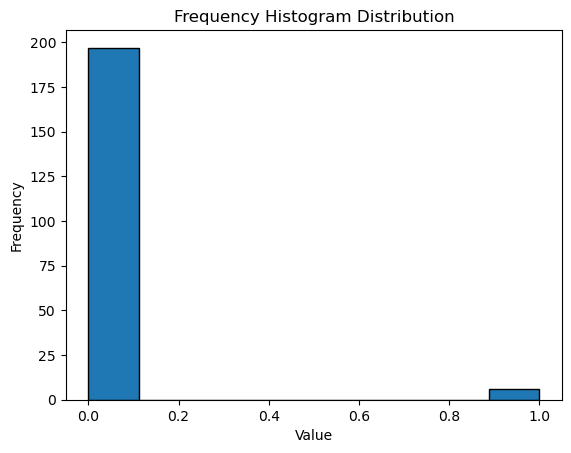

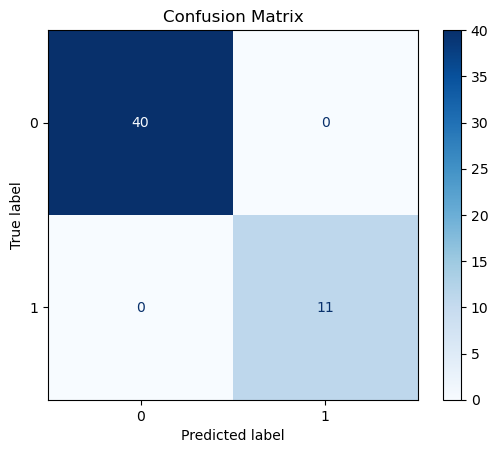

In [218]:
if __name__ == "__main__":
    ROOT =  "/Users/wmeikle/Downloads/archive-2/video/" # adjust if different
    T, SIZE, BATCH = 16, 112, 4

    train_ds = HighwayVideoClips(ROOT, T=T, size=SIZE, train=True)
    val_ds   = HighwayVideoClips(ROOT, T=T, size=SIZE, train=False)
    train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True, num_workers=0)
    val_loader   = DataLoader(val_ds, batch_size=BATCH, shuffle=False, num_workers=0)
    train_ds.summarize_counts(train_ds.labels)

    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = Simple3DCNN(num_classes=2).to(device)
    opt = optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.CrossEntropyLoss()

    for epoch in range(1):
        tr_loss, tr_acc = train_one_epoch(model, train_loader, opt, loss_fn, device)
        va_loss, va_acc, cm = evaluate(model, val_loader, loss_fn, device, return_cm=True, num_classes=2)
        print(f"Epoch {epoch+1}: train loss {tr_loss:.3f} acc {tr_acc:.3f} | val loss {va_loss:.3f} acc {va_acc:.3f}")
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(cmap=plt.cm.Blues) 
        plt.title('Confusion Matrix')
        plt.show()